In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the data

In [67]:
#open the locally saved csv
df = pd.read_csv('C:/Users/595217/general-assembly/project-final/data/mgm.csv', usecols=['description', 'jobtype', 'usetype'])

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17669 entries, 0 to 17668
Data columns (total 3 columns):
description    17669 non-null object
jobtype        17669 non-null object
usetype        17669 non-null object
dtypes: object(3)
memory usage: 414.2+ KB


In [69]:
df = df[df.usetype != 'Mixed Occupancy'] # remove Mixed Occupancy occurances as there are too few

### Create the features and target variables

In [70]:
X = df['description']
y = df['usetype']
z = df['jobtype']

In [71]:
y = y.map({'Commercial': 0, 'Residential': 1})
z = z.map({'New': 0, 'Existing': 1, 'Alteration': 2, 'Repair': 3, 'Other': 4, 'Addition': 5})

In [72]:
y.value_counts(), z.value_counts()

(1    10439
 0     7210
 Name: usetype, dtype: int64, 0    4820
 1    4017
 2    3083
 3    2322
 4    2264
 5    1143
 Name: jobtype, dtype: int64)

In [74]:
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split

In [75]:
# y_bin = label_binarize(y, classes=[0,1,2])
# n_y_bin_classes = y_bin.shape[1]
z_bin = label_binarize(z, classes=[0,1,2,3,4,5])
n_z_bin_classes = z_bin.shape[1]

In [76]:
X_tr, X_te, y_tr, y_te, = train_test_split(X, y, test_size=0.30, random_state=42)

In [77]:
# create the BOW representation
bow_transform = text.CountVectorizer(min_df=0, stop_words="english")
X_tr_bow = bow_transform.fit_transform(X_tr)
X_te_bow = bow_transform.transform(X_te)
len(bow_transform.vocabulary_)

8190

In [78]:
#create tf-idf representation using the bow matrix
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_trfm.transform(X_te_bow)
X_te_tfidf.shape

(5295, 8190)

### Instantiate a random forest and score

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [80]:
#instantiate the classifier
rf = RandomForestClassifier()

In [81]:
rf.fit(X_tr_tfidf, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
y_pred = rf.predict(X_te_tfidf)
print(rf.__class__.__name__, accuracy_score(y_te, y_pred))

RandomForestClassifier 0.9937677053824363


In [83]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("StDev:", scores.std())

In [84]:
y_tr_tfidf_scores = cross_val_score(rf, X_tr_tfidf, y_tr, cv=10, scoring="accuracy")

In [85]:
display_scores(y_tr_tfidf_scores)

Scores: [0.99433657 0.99271845 0.99514563 0.99514563 0.99110032 0.99110032
 0.99514563 0.98541329 0.99270665 0.99594814]
Mean: 0.9928760627947109
StDev: 0.002984569578523341


In [86]:
y_te_tfidf_scores = cross_val_score(rf, X_te_tfidf, y_te, cv=10, scoring="accuracy")

In [87]:
display_scores(y_te_tfidf_scores)

Scores: [0.98116761 0.9905838  0.99433962 0.98487713 0.98676749 0.98865784
 0.98487713 0.98676749 0.98487713 0.98109641]
Mean: 0.986401163998582
StDev: 0.0038519242512337648


In [88]:
y_score = rf.predict_proba(X_te_tfidf)

In [89]:
y_score

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [92]:
rf.fit(X_tr_tfidf, y_tr)
try:
    scores = rf.decision_function(X_te_tfidf)
except:
    scores = rf.predict_proba(X_te_tfidf)[:,1]

In [99]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_tr, y_tr_tfidf_scores)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

ValueError: Found input variables with inconsistent numbers of samples: [12354, 10]

Text(0.5,1,'2-class Precision-Recall curve: AP=1.00')

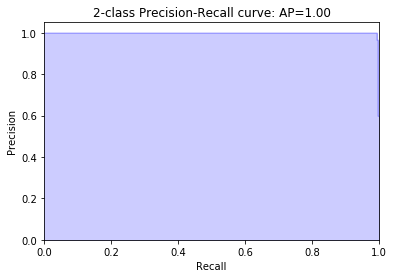

In [95]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_te, scores)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

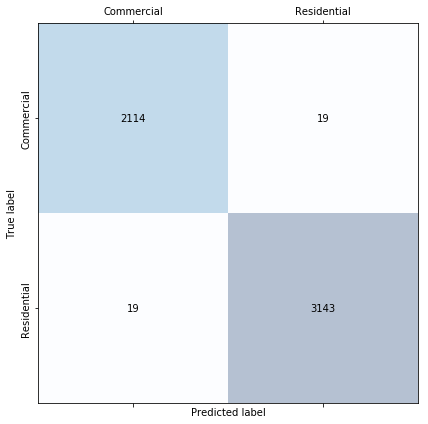

In [41]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
confmat_y = confusion_matrix(y_te, y_pred_classes)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_y, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_y.shape[0]):
    for j in range(confmat_y.shape[1]):
        ax.text(x=j, y=i, s=confmat_y[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['Commercial', 'Residential'])
plt.yticks([0, 1], ['Commercial', 'Residential'], rotation='vertical', va='center')
ax.grid(False)
plt.tight_layout()
plt.show()

### Convert predictions to text labels and join with the main dataframe to see where the errors occurred 

In [35]:
y_pred_classes = []
for i in y_pred:
    if i > .5:
        y_pred_classes.append(1)
    else:
        y_pred_classes.append(0)

In [36]:
real_v_pred = pd.concat([y_te.reset_index(), pd.Series(y_pred_classes)], axis=1, join='inner', ignore_index=True).reset_index(drop=True).set_index([1])

In [37]:
real_v_pred.reset_index(inplace=True)
real_v_pred.columns = ['test', 'index', 'pred']

In [38]:
errors = real_v_pred[real_v_pred.test != real_v_pred.pred]
errors.set_index(keys='index', inplace=True)

In [39]:
df_errors = df.join(errors, how='inner')

### Descriptions of where 'Residential' was misclassified

In [42]:
for row in df_errors['description'][df_errors.usetype == 'Residential']:
    print("-", row)

- GRADING PERMIT TO CLEAR NEW SUBDIVISION FOR RYAN RIDGE  RESIDENTIAL LOTS. PROPERTY IS IN A PRIORITY CONSTRUCTION SITE. NPDES PERMIT NO. ALR108382. TO MEET ALL APPLICABLE CODES.
- ALTERATIONS TO EXISTING 1,395 (UNIT H) SF OF COMMERCIAL BUILDING TO BE USED FOR LOANS COMPANY. ALL INSPECTIONS ARE REQUIRED BY ALL APPLICABLE DEPTS. STAMPED COPY OF PLANS AND REVIEW LETTER MUST BE KEPT ON JOB SITE AT ALL TIMES. TO MEET ALL APPLICABLE CODES.
- DEMOLISH EXISTING WOOD FRAME DWLLING TO CLERA LOT. HEALTH DEPT APPROVAL ON FILE. WATER WORKS NO. 5421. BOND NO. 321716. DEMOLITION MUST COMPLETED WITHIN 30 DAYS. TO MEET ALL APPLICABLE CODES.
- DEMOLISH commercial STRUCTURE TO CLEAR LOT. BOND #321705, WATER WORKS 5416 AND HEALTH DEPT LETTER ON FILE.  THIS PERMIT IS GOOD FOR 30 DAYS.  FINAL INSPECTION WILL BE REQUIRED BY HOUSING CODES. TO MEET ALL APPLICABLE CODERS.
- INSTALL A 10' X 25' SWIMMIING POOL ON SIDE OF EXISTING DWELLING.  44" FENCE IS REQUIRED AROUND AREA WITH A LOCKABLE GATE.  DIRT WILL BE US

### Descriptions of where 'Commercial' was misclassified

In [43]:
for row in df_errors['description'][df_errors.usetype == 'Commercial']:
    print("-", row)

- INSTALL 2-37.1/2" X 12'-5/8" ILLUMINATED CHANNEL LETTERS TO THE FACE OF AN EXISTING BUILDING AND 2-8 SQ FT. ILLUMINATED TENANT PANELS TO THE EXISTING TENANT POLE SIGN. UL NUMBERS C21762072 - C21762088, C21762089 - C21762105.  ALL INSPECTION REQ BY ALL APPLICABLE DEPTS.  TO MEET ALL APPLICABLE CODES.
- DEMOLISH EXISTING BRICK VENEER COMMERCIAL BUILDING. HEALTH DEPT. APPROVAL ON FILE. WATER WORKS CLEARANCE NO. 4609. BOND NO. 427529. FINAL INSPECTION WILL BE REQURIED BY BUILDING DEPT. AND WATER WORKS. TO MEET ALL APPLICABLE CODES.
- DEMOLISH EXISTING BRICK VENEER COMMERCIAL BUILDING. HEALTH DEPT. APPROVAL ON FILE. WATER WORKS CLEARANCE NO. 4609. BOND NO. 427529. FINAL INSPECTION WILL BE REQURIED BY BUILDING DEPT. AND WATER WORKS. TO MEET ALL APPLICABLE CODES.
- 12-11-2013 DEMOLISH COMMERCIAL STRUCTURE TO CLEAR LOT**NO FEE- WORK COMPLETED BY CITY LANDFILL
- GENERAL REPAIRS TO EXISTING APARTMENT 245-D OF EXISTING COMPLEX. FRAMING, ELEC, PLUMBING, MECHANICAL INSPECTONS WILL BE REQUIRED. TO